This is the start of our sign language detection project. Authors: Émilia and Arpan

In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions

from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf

import cv2
import os
import pickle
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://downloads.rclone.org/v1.57.0/rclone-v1.57.0-linux-amd64.deb

!apt install ./rclone-v1.57.0-linux-amd64.deb



In [ ]:
!rclone config

In [ ]:
!mkdir -p /content/onedrive

!nohup rclone mount onedrive: /content/onedrive &

nohup: appending output to 'nohup.out'


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#import glob
#glob.glob()
# change the runtime type to GPU

Mounted at /content/gdrive


In [ ]:
root_path = "/content/onedrive/2022-2023/AI/archive.zip"
root_path_Train_nums = '/content/Train_Nums'
root_path_Test_nums = '/content/Test_Nums'
!unzip "/content/onedrive/2022-2023/AI/alphabet_ASL.zip"
!unzip "/content/onedrive/2022-2023/AI/archive.zip"


In [ ]:
root_path_train_data = "/content/train_data"
root_path_test_data = "/content/test_data"
name_train_num_file = "Train_nums"
name_test_num_file = "Test_nums"
name_train_alph_file = "asl_alphabet_train"
name_test_alph_file = "asl_alphabet_test"

labels_alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','nothing','del','space']
labels_numbers = ['1','2','3','4','5','6','7','8','9','10','Blank']
labels = labels_alphabet + labels_numbers
img_size = 224
nb_classes = len(labels_numbers) + len(labels_alphabet)

In [3]:
#!unzip $root_path
!unzip '/content/gdrive/MyDrive/asl_alphabet_train.zip'
!unzip '/content/gdrive/MyDrive/asl_alphabet_test.zip'
root_path_train_data = '/content/asl_alphabet_train'
root_path_test_data = '/content/asl_alphabet_test'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/Y/Y2960.jpg  
  inflating: asl_alphabet_train/Y/Y2961.jpg  
  inflating: asl_alphabet_train/Y/Y2962.jpg  
  inflating: asl_alphabet_train/Y/Y2963.jpg  
  inflating: asl_alphabet_train/Y/Y2964.jpg  
  inflating: asl_alphabet_train/Y/Y2965.jpg  
  inflating: asl_alphabet_train/Y/Y2966.jpg  
  inflating: asl_alphabet_train/Y/Y2967.jpg  
  inflating: asl_alphabet_train/Y/Y2968.jpg  
  inflating: asl_alphabet_train/Y/Y2969.jpg  
  inflating: asl_alphabet_train/Y/Y297.jpg  
  inflating: asl_alphabet_train/Y/Y2970.jpg  
  inflating: asl_alphabet_train/Y/Y2971.jpg  
  inflating: asl_alphabet_train/Y/Y2972.jpg  
  inflating: asl_alphabet_train/Y/Y2973.jpg  
  inflating: asl_alphabet_train/Y/Y2974.jpg  
  inflating: asl_alphabet_train/Y/Y2975.jpg  
  inflating: asl_alphabet_train/Y/Y2976.jpg  
  inflating: asl_alphabet_train/Y/Y2977.jpg  
  inflating: asl_alphabet_train/Y/Y2978.jpg  
  inflating: asl_alphabet_trai

Step 2: Loading the data

In [ ]:
labels_alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','nothing','del','space']
labels_numbers = ['1','2','3','4','5','6','7','8','9','10','Blank']
labels = labels_alphabet + labels_numbers
img_size = 224
nb_classes = len(labels_numbers) + len(labels_alphabet)

def get_data(data_dir):
  data = []
  for label in labels:

    if "train" in str(data_dir):
      if label in labels_numbers:
        folder_name = name_train_num_file
      else:
        folder_name = name_train_alph_file

    if "test" in str(data_dir):
      if label in labels_numbers:
        folder_name = name_test_num_file
      else:
        folder_name = name_test_alph_file

    path = os.path.join(data_dir, folder_name, label)
    print(path)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)
  
train_numbers = get_data(root_path_train_data)
test_numbers = get_data(root_path_test_data)



In [ ]:
labels_alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space']
labels_numbers = ['1','2','3','4','5','6','7','8','9','10','Blank']
labels = labels_alphabet + labels_numbers
img_size = 224
nb_classes = len(labels_numbers) + len(labels_alphabet)

root_path_train = '/content/asl_alphabet_train'
root_path_test = '/content/asl_alphabet_test'

def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)
  
train_numbers = get_data(root_path_train)
test_numbers = get_data(root_path_test)

Step 3: Visualize the data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '1')

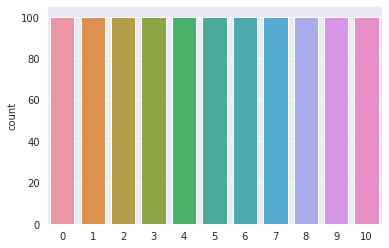

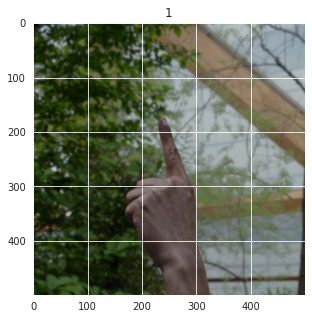

In [ ]:
#This block of code helps us visualize our dataset and see how many images of every label do we have
occurance = []
for img_number in train_numbers:
  occurance.append(img_number[1]) #this append the label of the image
sns.set_style('darkgrid')
sns.countplot(occurance)

#This is just fun because we can visualize images from the dataset if we need
plt.figure(figsize = (5,5))
plt.imshow(train_numbers[1][0]) #train_numbers[1][0] gives the jpeg file
plt.title(labels_numbers[train_numbers[0][1]]) #train_numbers[0][1] gives the label of the image

Step 4: Data augmentation

In [6]:
labels = ['1','10','2','3','4','5','6','7','8','9','A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space']
img_size = 224
nb_classes = len(labels)

In [4]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_generator = datagen.flow_from_directory(root_path_train_data, target_size=(224, 224), batch_size=50)

test_generator = datagen.flow_from_directory(root_path_test_data, target_size=(224,224), batch_size=50)

"""
train_datagen.fit_generator(train_generator)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory("/content/Test_Nums", target_size=(224,224))
test_datagen.fit_generator(test_generator)

"""




Found 96900 images belonging to 39 classes.
Found 1138 images belonging to 39 classes.


'\ntrain_datagen.fit_generator(train_generator)\ntest_datagen = ImageDataGenerator()\ntest_generator = test_datagen.flow_from_directory("/content/Test_Nums", target_size=(224,224))\ntest_datagen.fit_generator(test_generator)\n\n'

Step 5: Defining our model

model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(nb_classes, activation="softmax")) 

opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history = model.fit(x_nb_train,y_nb_train,epochs = 500 , validation_data = (x_nb_val, y_nb_val))


In [9]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_size,img_size,3),
                   pooling='max',classes=nb_classes,
                   weights="imagenet")

'''
pretrained_model = tf.keras.applications.VGG19(
                  include_top=False,
                  weights=None,
                  input_tensor=None,
                  input_shape=None,
                  pooling='max',
                  classes=nb_classes,
                  classifier_activation="softmax")
'''


#for layer in pretrained_model.layers:
#        layer.trainable=False


resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(nb_classes, activation='softmax'))

resnet_model.summary()

resnet_model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


history = resnet_model.fit_generator(train_generator, validation_data=test_generator, epochs=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 39)                20007     
                                                                 
Total params: 24,656,807
Trainable params: 24,603,687
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


   4/1938 [..............................] - ETA: 23:37:05 - loss: 12.3857 - accuracy: 0.0250

KeyboardInterrupt: ignored

Saving the model

In [ ]:
with open('model_history', 'wb') as history_file:
    pickle.dump(history.history, history_file)

resnet_model.save("Model_number_only_2_epoch")

In [64]:
model = load_model('/content/gdrive/MyDrive/Model_2_epoch')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Step 6: Visualizing our results

In [ ]:

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(6)

# plt.figure(figsize=(15, 15))
# # plt.subplot(2, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

predictions = resnet_model.predict_generator(test_generator)
print(len(predictions))
print(len(y_nb_train))
predictions = predictions.reshape(1,-1)[0]
# print(classification_report(y_nb_train, predictions, target_names = labels_numbers))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


1138
0


<IPython.core.display.Javascript object>

Saved to photo.jpg


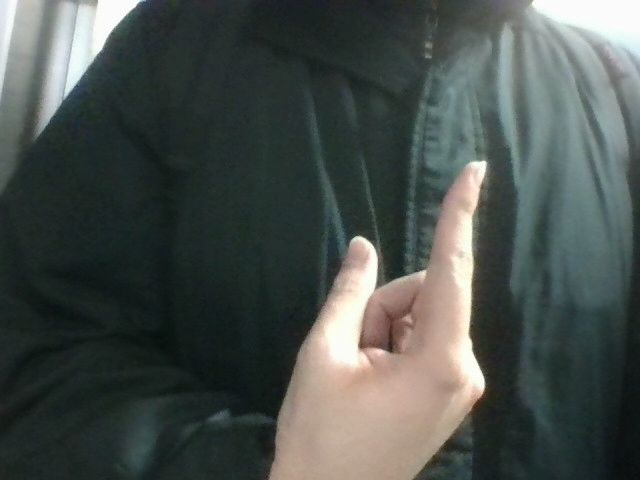

In [74]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
  
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# dimensions of our images
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions

img_size = 224

# load the model we saved
model = load_model('/content/model_history')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

# predicting images


In [62]:
labels = ['1','10','2','3','4','5','6','7','8','9','A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space']
# img_size = 224
img = tf.keras.utils.load_img('photo.jpg')
# plt.figure(figsize = (5,5))
# plt.imshow(img)

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
processed_image = tf.keras.applications.resnet50.preprocess_input(x.copy())

predictions = model.predict(processed_image)
print(predictions)

max = np.argmax(predictions)
index_to_letter_map = {i: x for i, x in enumerate(labels)}

print(index_to_letter_map[max])

1/1 [==============================] - 1s 1s/step
[[2.1223665e-05 5.0885844e-01 6.7710585e-05 2.2197755e-01 7.9242291e-04
  2.9575854e-04 6.5532873e-08 1.3866466e-04 5.1305534e-07 4.2154349e-07
  1.1212332e-07 1.5561475e-06 2.7392639e-04 1.8353490e-05 3.0997738e-09
  3.1628537e-05 1.6845555e-06 4.4261509e-07 8.6088539e-06 2.7502392e-07
  2.4259100e-06 7.9033304e-09 3.9002821e-08 1.0818857e-05 9.3881683e-03
  1.5596545e-07 1.8158566e-07 7.5446325e-09 8.0869604e-08 2.2946018e-07
  2.1657668e-05 1.3514642e-06 2.0604075e-07 1.7712032e-10 2.9577235e-05
  5.5326225e-08 4.9703183e-05 2.5791922e-01 8.6676111e-05]]
10


In [89]:
img = tf.keras.utils.load_img('photo.jpg')
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
processed_image = tf.keras.applications.resnet50.preprocess_input(x.copy())

predictions = resnet_model.predict(processed_image)

classes_x=np.argmax(predictions,axis=1)

print(classes_x)

1/1 [==============================] - 0s 27ms/step
[1]


In [ ]:
from keras.applications.imagenet_utils import decode_predictions

label = decode_predictions(predictions)
print(label)

In [ ]:
def preprocess_image(image, best_model):

    # image = tf.reshape(image, [image.shape[0], image.shape[1], 1])
    # image = image/255
    # image = tf.image.resize(image, [28, 28], preserve_aspect_ratio=True)
    
    # preprocessed_image = np.ones((1, 28, 28, 1))
    # preprocessed_image[0, :image.shape[0], :image.shape[1], :] = image

    x = tf.keras.utils.img_to_array(image)
    x = np.expand_dims(x, axis=0)
    processed_image = tf.keras.applications.resnet50.preprocess_input(x.copy())
    prediction = best_model.predict(processed_image)
    
    index_to_letter_map = {f'{i}': x for i, x in enumerate(labels)}
    letter = index_to_letter_map[label_binarizer.inverse_transform(prediction)[0]]
    return letter

img_size = 224
img = tf.keras.utils.load_img('/content/asl_alphabet_train/3/006d85d1-a3fd-417a-94ae-f025d35bfb09.rgb_0000.png', target_size=(img_size, img_size))
print(preprocess_image(img, resnet_model))

In [54]:
index_to_letter_map = {f'{i}': x for i, x in enumerate(labels)}
print(index_to_letter_map)

{'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I', '9': 'J', '10': 'K', '11': 'L', '12': 'M', '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S', '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y', '25': 'Z', '26': 'del', '27': 'space', '28': '1', '29': '2', '30': '3', '31': '4', '32': '5', '33': '6', '34': '7', '35': '8', '36': '9', '37': '10', '38': 'Blank'}


In [75]:
from PIL import Image

def preprocess_image(img, best_model):
    labels = ['1','10','2','3','4','5','6','7','8','9','A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space']
    # img_size = 224
    # img = tf.keras.utils.load_img(image)
    # # plt.figure(figsize = (5,5))
    # # plt.imshow(img)

    # image = tf.keras.utils.img_to_array(img)
    
    # image = tf.reshape(image, [image.shape[0], image.shape[1], 1])
    # image = image/255
    # image = tf.image.resize(image, [28, 28], preserve_aspect_ratio=True)
    
    # preprocessed_image = np.ones((1, 28, 28, 1))
    # preprocessed_image[0, :image.shape[0], :image.shape[1], :] = image


    # processed_image = tf.keras.applications.resnet50.preprocess_input(x.copy())
    
    img = tf.keras.utils.load_img('photo.jpg')
    img = img.resize((224,224))
    img_array = tf.keras.utils.img_to_array(img)


    img_batch = np.expand_dims(img_array, axis=0)

    processed_image = tf.keras.applications.resnet50.preprocess_input(img_batch)
    predictions = best_model.predict(processed_image)

    max = np.argmax(predictions)
    index_to_letter_map = {i: x for i, x in enumerate(labels)}
    letter = index_to_letter_map[max]

    return letter

image = Image.open('photo.jpg').convert('L')
    
letter = preprocess_image(image, model)
print(f'The image is predicted as {letter}')

1/1 [==============================] - 0s 228ms/step
The image is predicted as 2
